# <font style="color:#008fff;">Machine Learning Modeling Part 2</font>
<hr>

In [1]:
import pandas as pd
import numpy as np
import time
import os
import sklearn
import warnings
import sys
import random
import pickle
import collections 

# Importing feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

# ML Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier

# Evaluation Metrics/Visualizations
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt

#Disabling Warnings
warnings.filterwarnings('ignore')

# to make this notebook's output stable across runs
random.seed(42)

## <font style="color:#008fff;">Helper Functions</font>

In [2]:
def loadDataset(file_name, idx_col=False):
    start_time= time.time()
    if idx_col:
        df = pd.read_csv(file_name, index_col=[0])
    else:
        df = pd.read_csv(file_name)
    print("***Elapsed time to read csv files --- %s seconds ---***" % (time.time() - start_time))
    return df

In [3]:
from profanity_check import predict_prob, predict
from urllib.parse import urlparse
from tld import get_tld

# Getting rid of outliers using clamp transformation
def find_outliers_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    
    for index, val in df.iteritems():
        if val < (q1 - 1.5 * IQR): # Small outliers below lower quartile
            df[index] = (q1 - 1.5 * IQR)
        elif val > (q3 + 1.5 * IQR): # Large outliers above upper quartile
            df[index] = (q3 + 1.5 * IQR)

    return df

# If tld == gov, then is_gov_tld = 1, else gov_tld = 0
def make_gov_column(df):
    gov_col = []
    for index, val in df.iteritems():
        if val == 'gov':
            gov_col.append(1)
        else:
            gov_col.append(0)
    return np.array(gov_col)


def clean_url(url):
    url_text=""
    try:
        domain = get_tld(url, as_object=True)
        domain = get_tld(url, as_object=True)
        url_parsed = urlparse(url)
        url_text= url_parsed.netloc.replace(domain.tld," ").replace('www',' ') +" "+ url_parsed.path+" "+url_parsed.params+" "+url_parsed.query+" "+url_parsed.fragment
        url_text = url_text.translate(str.maketrans({'?':' ','\\':' ','.':' ',';':' ','/':' ','\'':' '}))
        url_text.strip(' ')
        url_text.lower()
    except:
        url_text = url_text.translate(str.maketrans({'?':' ','\\':' ','.':' ',';':' ','/':' ','\'':' '}))
        url_text.strip(' ')
    return url_text

def predict_profanity(url_cleaned):
    arr=predict_prob(url_cleaned.astype(str).to_numpy())
    arr= arr.round(decimals=3)
    #df['url_vect'] = pd.DataFrame(data=arr,columns=['url_vect'])
    return arr

In [4]:
def preprocess(df):
    start_time= time.time()

    # ------------ Address outliers via clamp transformation --------------
    url_len_clamped = df['url_len'].copy()
    url_len_clamped = find_outliers_IQR(url_len_clamped)
    js_len_clamped = df['js_len'].copy()
    js_len_clamped = find_outliers_IQR(js_len_clamped)
    js_obf_len_clamped = df['js_obf_len'].copy()
    js_obf_len_clamped = find_outliers_IQR(js_obf_len_clamped)
    
    df['url_len'] = url_len_clamped
    df['js_len'] = js_len_clamped
    df['js_obf_len'] = js_obf_len_clamped
    
    # --------------- Scaling numerical features ---------------
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    
    url_len_scaled = scaler.fit_transform(df[['url_len']])
    df['url_len_scaled'] = url_len_scaled

    js_len_scaled = scaler.fit_transform(df[['js_len']])
    df['js_len_scaled'] = js_len_scaled

    js_obf_len_scaled = scaler.fit_transform(df[['js_obf_len']])
    df['js_obf_len_scaled'] = js_obf_len_scaled
    
    
    # ---------------- Binary Encoding for Categorical Attributes ------------------
    identifyWho_Is = {'incomplete': 0, 'complete': 1}
    df['who_is'] = [identifyWho_Is[item] for item in df.who_is]
    
    identifyHTTPS = {'no': 0, 'yes': 1}
    df.https = [identifyHTTPS[item] for item in df.https]
    
    # --------------- Handling TLD Column -------------------------
    gov_binary_val = make_gov_column(df['tld'])
    df.insert(2, column = "is_gov_tld", value=gov_binary_val)
    
    
    # ---------------- Probabilty based profanity score on text columnsk ------------------
    from profanity_check import predict_prob, predict
    profanity_score_prob = predict_prob(np.array(df['content']))
    df.insert(5, column='profanity_score_prob', value=profanity_score_prob)
    
    
    # ------------------ Cleaning URL's --------------------
    url_cleaned = df['url'].map(clean_url)
    df.insert(1, column='url_cleaned', value=url_cleaned)
    url_vect = predict_profanity(df['url_cleaned'])
    df.insert(2, column='url_vect', value=url_vect)
    
    # ---------------------- Preprocess labels into binary values ----------------------
    identifyLabels = {'bad': 1, 'good': 0}
    df['label'] = [identifyLabels[item] for item  in df.label]
    
    # ------------ Drop Unecessary Columns, or Original Columns after preprocessing that still remain -------------
    df.drop(['geo_loc', 'ip_add', 'url_len', 'js_len', 'js_obf_len', 'tld', 'content', 'url', 'url_cleaned'], axis=1, inplace=True)
    
    # ---------------------- Rearrange Columns ----------------------
    titles = ['url_vect', 'is_gov_tld', 'who_is', 'https', 'profanity_score_prob', 
              'url_len_scaled', 'js_len_scaled','js_obf_len_scaled',
              'label'] # Same order as our training data

    df = df[titles] 
    
    print("***Elapsed time preprocess --- %s seconds ---***" % (time.time() - start_time))
    return df

In [5]:
# Add values on top of bars
def add_labels(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', rotation=90)

In [6]:
def draw_conf_matrix(actual, predicted, title):
    plt.figure(figsize = (7,5))
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    cf_matrix = confusion_matrix(actual, predicted)
    ht_mp = sns.heatmap(cf_matrix, annot=True, fmt='g')
    
    # **NOTE: In this case: Legitimate (NOT Malicious) is our NEGATIVE class, while Malicious is our POSITIVE class**
    ht_mp.set(xlabel='Predicted', ylabel='Actual', 
              xticklabels=['Not Malicious (Negative)', 'Malicious (Positive)'], 
              yticklabels=['Not Malicious (Negative)', 'Malicious (Positive)'])

## <font style="color:#008fff;">Loading Fine-Tuned Models</font>

### Fine-tuned moedls based on full feature sets:

In [7]:
# ---------------------- KNN ----------------------
knn_full_filename = 'Models/Optimized/knn_full_features_opt.sav' # Full feature set
knn_full = pickle.load(open(knn_full_filename, 'rb'))

# ---------------------- Naive Bayes ----------------------
gnb_full_filename = 'Models/Optimized/gnb_full_features_opt.sav'
gnb_full = pickle.load(open(gnb_full_filename, 'rb'))

# ---------------------- Decision Trees ----------------------
dc_full_filename = 'Models/Optimized/dc_full_features_opt.sav'
dc_full = pickle.load(open(dc_full_filename, 'rb'))

# ---------------------- Random Forest ----------------------
rfc_full_filename = 'Models/Optimized/rfc_full_features_opt.sav'
rfc_full = pickle.load(open(rfc_full_filename, 'rb'))

### Fine-tuned models based on reduced feature sets:

In [8]:
knn_reduced_filename = 'Models/Optimized/knn_reduced_features_opt.sav' # Reduced feature set
knn_reduced = pickle.load(open(knn_reduced_filename, 'rb'))

gnb_reduced_filename = 'Models/Optimized/gnb_reduced_features_opt.sav'
gnb_reduced = pickle.load(open(gnb_reduced_filename, 'rb'))

dc_reduced_filename = 'Models/Optimized/dc_reduced_features_opt.sav'
dc_reduced = pickle.load(open(dc_reduced_filename, 'rb'))

rfc_reduced_filename = 'Models/Optimized/rfc_reduced_features_opt.sav'
rfc_reduced = pickle.load(open(rfc_reduced_filename, 'rb'))

## <font style="color:#008fff;">Preprocessed Data</font>

In [9]:
# Splitting our test dataset into X and y
X_train = pd.read_csv('Dataset/preprocessed_training_data.csv').drop('label', axis=1)
y_train = pd.read_csv('Dataset/preprocessed_training_data.csv')['label']

X_test = pd.read_csv('Dataset/preprocessed_testing_data.csv').drop('label', axis=1)
y_test = pd.read_csv('Dataset/preprocessed_testing_data.csv')['label']

## <font style="color:#008fff;">Using All 4 Models to Vote</font>

### In this section, we will try to combine all 4 models: KNN, Naive Bayes, Decision Trees, and Random Forests to do a majority vote. We will have one trial all models trained on full feature sets to take a vote per data point, as well as another trial where all models trained on reduced feature sets will also take a vote. We will then compare results from both trials

**Models Trained on Reduced Feature Sets:**

In [10]:
# Function to have all 4 models make a majority vote
def vote_predictions(row):
    all_cols = ['url_vect', 'is_gov_tld', 'who_is', 'https', 'profanity_score_prob', 'url_len_scaled', 'js_len_scaled', 'js_obf_len_scaled']
    X = [row.loc[all_cols]]

    # Each models predicts
    preds = []
    preds.append(knn_full.predict(X)[0])
    preds.append(gnb_full.predict(X)[0])
    preds.append(dc_full.predict(X)[0])
    preds.append(rfc_full.predict(X)[0])
    
    vote_counts = collections.Counter(preds)
    
    if vote_counts[0] > vote_counts[1]:
        return 0
    elif vote_counts[0] < vote_counts[1]:
        return 1
    else: # If tie, randomly choose either one
        return random.choice([0, 1])


start_time = time.time()

predictions_full = []
for index, row in X_test.iterrows():
    # Take majority vote
    vote = vote_predictions(row)
    predictions_full.append(vote)
    
    
print("***Elapsed time to make predictions --- %s seconds ---***" % (time.time() - start_time))

***Elapsed time to make predictions --- 111.01114654541016 seconds ---***


**Models Trained on Reduced Feature Sets:**

In [11]:
# Function to have all 4 models make a majority vote
def vote_predictions(row):
    reduced_features_1 = ['who_is', 'https', 'profanity_score_prob', 'js_len_scaled', 'js_obf_len_scaled']
    knn_input = [row.loc[reduced_features_1]]
    
    reduced_features_2 = ['url_vect', 'is_gov_tld', 'js_obf_len_scaled']
    gnb_dc_rfc_input = [row.loc[reduced_features_2]]
    
    # Each models predicts
    preds = []
    preds.append(knn_reduced.predict(knn_input)[0])
    preds.append(gnb_reduced.predict(gnb_dc_rfc_input)[0])
    preds.append(dc_reduced.predict(gnb_dc_rfc_input)[0])
    preds.append(rfc_reduced.predict(gnb_dc_rfc_input)[0])
    
    vote_counts = collections.Counter(preds)
    
    if vote_counts[0] > vote_counts[1]:
        return 0
    elif vote_counts[0] < vote_counts[1]:
        return 1
    else: # If tie, randomly choose either one
        return random.choice([0, 1])


start_time = time.time()

predictions_reduced = []
for index, row in X_test.iterrows():
    # Take majority vote
    vote = vote_predictions(row)
    predictions_reduced.append(vote)
    
    
print("***Elapsed time to make predictions --- %s seconds ---***" % (time.time() - start_time))

***Elapsed time to make predictions --- 96.16473531723022 seconds ---***


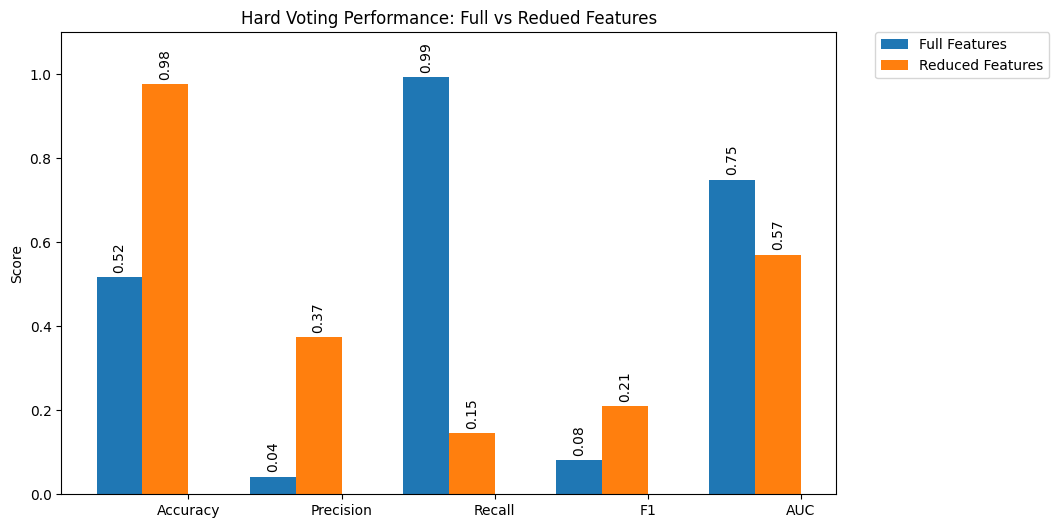

In [12]:
full_metrics = [
    accuracy_score(y_true=y_test, y_pred=predictions_full),
    precision_score(y_true=y_test, y_pred=predictions_full),
    recall_score(y_true=y_test, y_pred=predictions_full),
    f1_score(y_true=y_test, y_pred=predictions_full),
    roc_auc_score(y_true=y_test, y_score=predictions_full)
]

reduced_metrics = [
    accuracy_score(y_true=y_test, y_pred=predictions_reduced),
    precision_score(y_true=y_test, y_pred=predictions_reduced),
    recall_score(y_true=y_test, y_pred=predictions_reduced),
    f1_score(y_true=y_test, y_pred=predictions_reduced),
    roc_auc_score(y_true=y_test, y_score=predictions_reduced)
]

# create a list of model names
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']

# Plot
fig, ax = plt.subplots(figsize=(10,6))
x = np.arange(len(labels))
width = 0.3

rects1 = ax.bar(x - 1.5*width, full_metrics, width, label='Full Features')
rects2 = ax.bar(x - 0.5*width, reduced_metrics, width, label='Reduced Features')

add_labels(rects1, ax)
add_labels(rects2, ax)

# Formatting
ax.set_ylabel('Score')
ax.set_ylim([0, 1.1])
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title('Hard Voting Performance: Full vs Redued Features')
plt.show()

### What if we combined 4 models froll full and reduced feature sets to make a vote? 8 models total to make majority vote?

In [13]:
# Function to have all 8 models make a majority vote
def vote_predictions(row):
    preds = []
    
    all_cols = ['url_vect', 'is_gov_tld', 'who_is', 'https', 'profanity_score_prob', 'url_len_scaled', 'js_len_scaled', 'js_obf_len_scaled']
    X = [row.loc[all_cols]]

    # ------------- Models for FULL feature sets -------------
    preds.append(knn_full.predict(X)[0])
    preds.append(gnb_full.predict(X)[0])
    preds.append(dc_full.predict(X)[0])
    preds.append(rfc_full.predict(X)[0])
    
    # ------------- Models for REDUCED feature sets -------------
    reduced_features_1 = ['who_is', 'https', 'profanity_score_prob', 'js_len_scaled', 'js_obf_len_scaled']
    knn_input = [row.loc[reduced_features_1]]
    reduced_features_2 = ['url_vect', 'is_gov_tld', 'js_obf_len_scaled']
    gnb_dc_rfc_input = [row.loc[reduced_features_2]]
    
    preds.append(knn_reduced.predict(knn_input)[0])
    preds.append(gnb_reduced.predict(gnb_dc_rfc_input)[0])
    preds.append(dc_reduced.predict(gnb_dc_rfc_input)[0])
    preds.append(rfc_reduced.predict(gnb_dc_rfc_input)[0])
    
    # Aggregating votes
    vote_counts = collections.Counter(preds)
    if vote_counts[0] > vote_counts[1]:
        return 0
    elif vote_counts[0] < vote_counts[1]:
        return 1
    else: # If tie, randomly choose either one
        return random.choice([0, 1])


start_time = time.time()

final_predictions = []
for index, row in X_test.iterrows():
    # Take majority vote
    vote = vote_predictions(row)
    final_predictions.append(vote)
    
    
print("***Elapsed time to make predictions --- %s seconds ---***" % (time.time() - start_time))

***Elapsed time to make predictions --- 177.90418887138367 seconds ---***


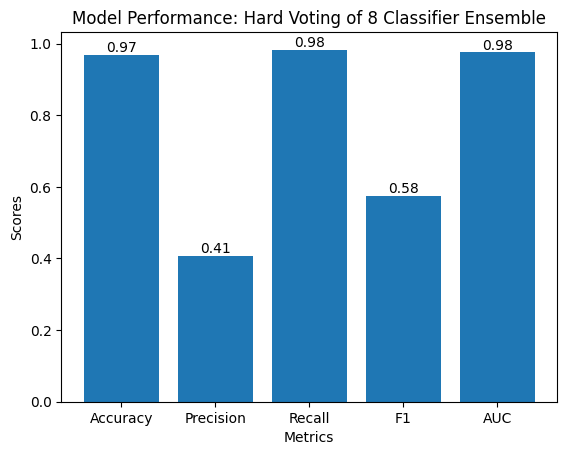

In [14]:
# Example data
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
scores = [accuracy_score(y_true=y_test,y_pred=final_predictions), 
          precision_score(y_true=y_test,y_pred=final_predictions), 
          recall_score(y_true=y_test,y_pred=final_predictions), 
          f1_score(y_true=y_test,y_pred=final_predictions), 
          roc_auc_score(y_true=y_test,y_score=final_predictions)]

# Create a bar plot
fig, ax = plt.subplots()
ax.bar(metrics, scores)

# Add values above each bar
for i, v in enumerate(scores):
    ax.text(i, v, str(round(v, 2)), ha='center', va='bottom')

# Set labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Performance: Hard Voting of 8 Classifier Ensemble')

# Show the plot
plt.show()

Metrics seem to have great improvement

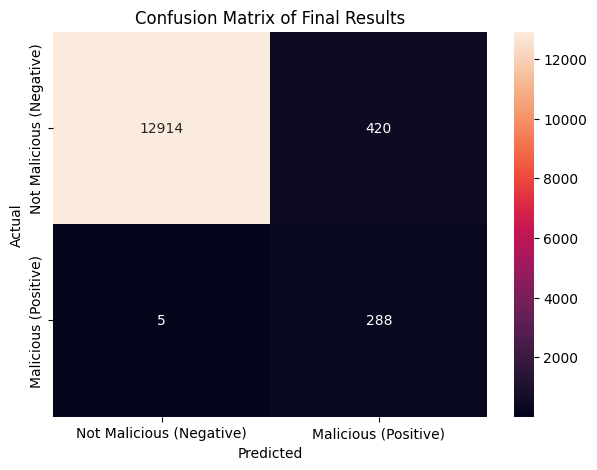

In [15]:
draw_conf_matrix(y_test, final_predictions, 'Confusion Matrix of Final Results')